# Neural differential equations

As illustrated in the [previous notebook](./01-machine-learning.ipynb), neural networks are a non-linear combination of linear functions, e.g.,

$$f(x) = \mathrm{tanh}\left(a_1\left(a_2\,\mathrm{tanh}(x)+b_2  \right)+b_1\right)$$

Systems with time dynamics are often described by differential equations (e.g. reaction kinetics),

$$\cfrac{\mathrm{d}x(t)}{\mathrm{d}t} = v(t)$$

This equation describes the evolution of the distance ($x$) as a function of time.

Often, the phenomena we want to model involve complex dynamics in which case a machine learning approach can be adopted where the dynamics are learned from experiments rather than mechanistic knowledge. Since we already introduced artificial neural networks and differential equations, let us combine the two,

$$\cfrac{\mathrm{d}x(t)}{\mathrm{d}t} = \mathrm{tanh}\left(a_1\left(a_2\,\mathrm{tanh}(x)+b_2  \right)+b_1\right)\, .$$

Et voila! We have a neural differential equations. Neural differential equation are a natural way of learning from timeseries. They can also be easily coupled with existing process models. This is show in the [final notebook](./03-hybrid.ipynb), but first, let's put this methodology to test.

## Learning biochemical reaction dynamics

We have some data on the production of sucrose esters,

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Sucrose_monostearate.svg/500px-Sucrose_monostearate.svg.png)

Which can be produced by using reacting a lipase enzyme in an organic solvent, forcing the reverse reaction, 

sucrose (S) + fatty acid (A) ⇄ sucrose fatty acid ester (Es) + water. 

The reaction kinetics are complex due to due to substrate and product inhibition.

In [29]:
include("./src/helper-functions.jl");

In [30]:
using OrdinaryDiffEq, Plots
import Random
Random.seed!(1234);

In [31]:
C₀ = Float32[45.0; 60.0; 0.0]
tₑ = 360.0f0;

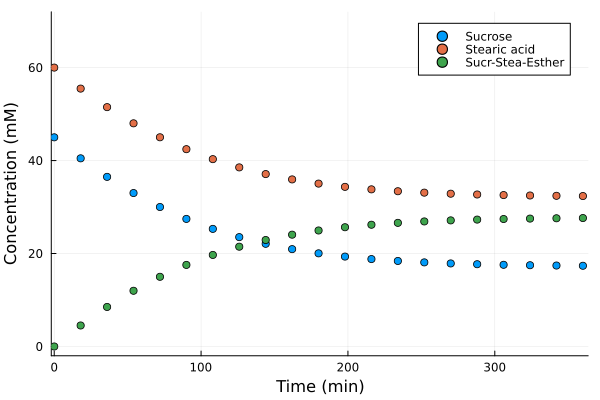

In [32]:
data = generate_true_solution(C₀, tₑ);
plot_reaction(data)

## Training on a single experiment

In [33]:
C, time = data;

In [34]:
using DiffEqFlux, Flux

1 **Define a neural network**

In [35]:
ann = Flux.Chain(Flux.Dense(3, 20, σ), Flux.Dense(20, 8, σ), Flux.Dense(8,1), x->x.*[1.0f0; 1.0f0; -1.0f0])

Chain(
  Dense(3 => 20, σ),                    # 80 parameters
  Dense(20 => 8, σ),                    # 168 parameters
  Dense(8 => 1),                        # 9 parameters
  var"#52#53"(),
)                   # Total: 6 arrays, 257 parameters, 1.379 KiB.

**2 Separate structure and parameters**

In [36]:
p, re = Flux.destructure(ann) # use this p as the initial condition!

(Float32[-0.34187603, 0.08157978, 0.13460904, -0.090613775, -0.09418556, 0.48229071, -0.40809503, -0.4955245, -0.14949362, 0.020792779  …  0.0, 0.14780359, -0.697009, -0.0658151, 0.002867459, -0.10743978, 0.66452926, -0.18083437, -0.6258136, 0.0], Restructure(Chain, ..., 257))

**3. Define our neural ODE**

The reaction rate for every component is the same (excluding the sign) since one molecule of sucrose combines with one molecule of stearic acid to form a single molecule of the esther.

The neural network that will be training is.

$$\cfrac{\mathrm{d}C_i}{\mathrm{d}t} = ANN\left(C_{sucr}, C_{stea}, C_{Es}\right) $$

In [37]:
dCdt(u,p,t) = re(p)(u) # need to restrcture for backprop!



dCdt (generic function with 1 method)

At this point the neural ODE is handled as any other ODE. For more information on how to solve ODEs in julia, please consult the [DifferentialEquation.jl documentation](https://diffeq.sciml.ai/stable/).

In [38]:
prob = ODEProblem(dCdt, C₀, (0, tₑ))

function predict_neuralODE(C₀)
    Array(solve(prob,Tsit5(),u0=C₀,p=p,saveat=time))
end

predict_neuralODE (generic function with 1 method)

**4. Define a loss function**

We need some measure to compare the simulation results with the data

In [39]:
L₁() = sum((C.-predict_neuralODE(C₀)).^2); # sum of squared-errors

Lastly we define a callback function that is executed during training. Here is just plots the simulation results every training iteration. Pretty nice!

In [40]:
cb = function (;doplot = true)
  # plot current prediction against data
    pred = predict_neuralODE(C₀)
    pl = prediction_vs_data(data, pred)
    
    if doplot
        IJulia.clear_output(true)
        display(plot(pl))
    end
    return false
end

#54 (generic function with 1 method)

In [41]:
epochs = Iterators.repeated((), 300)
Flux.train!(L₁, Flux.params(p), epochs, ADAM(0.04), cb = cb)

### Testing

Now that we have trained the model let's see how it predicts the reaction rate for a other initial concentrations.

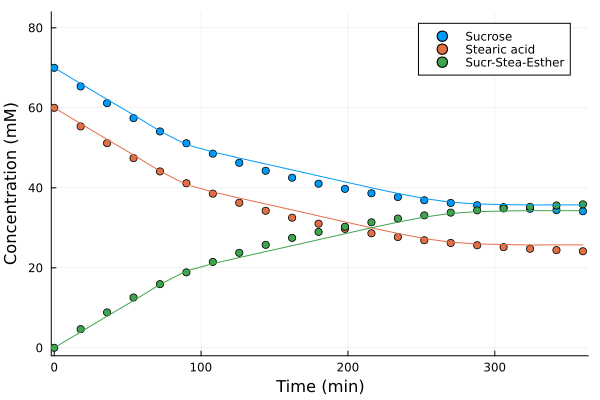

In [42]:
C₀ = Float32[70.0; 60.0; 0.0]
data = generate_true_solution(C₀, tₑ);
pred = predict_neuralODE(C₀)
pl = prediction_vs_data(data, pred)

Not bad, but definitely not great either. In case we want to use the model in a CSTR we need to train the model on more experimental data.

## Adding more experiments

Let's perform 9 lab batch tests with different initial concentrations.

In [43]:
initialConditions = 
[
    Float32[30.0; 60.0; 0.0],
    Float32[45.0; 60.0; 0.0],
    Float32[60.0; 60.0; 0.0],
    Float32[30.0; 60.0; 15.0],
    Float32[45.0; 60.0; 15.0],
    Float32[60.0; 60.0; 15.0],
    Float32[30.0; 60.0; 30.0],
    Float32[45.0; 60.0; 30.0],
    Float32[60.0; 60.0; 30.0],
];

In [44]:
datasets = [generate_true_solution(C₀, tₑ) for C₀ in initialConditions];

The training loss is now extened to sum the previously defined loss function over all experiments. 

In [45]:
function trainingLoss()
    loss = 0.0f0
        
    for (index, C₀) in enumerate(initialConditions)
        C, time = datasets[index]  
        pred = predict_neuralODE(C₀)
        loss += sum((C.-pred).^2);
    end
    return loss
end;

Define a callback function to plot 4 of the 9 experiments

In [46]:
cb4 = function (;doplot = true)
  # plot current prediction against data
    
    l = @layout [a b; c d]
    pls = []
    for C₀ in initialConditions[1:4]
        data = generate_true_solution(C₀, tₑ);
        C, time = data  
        pred = predict_neuralODE(C₀)
        push!(pls, prediction_vs_data(data, pred))
    end
    
    if doplot
        IJulia.clear_output(true)
        pl = plot(pls[1], pls[2], pls[3], pls[4], layout = l, size=(900, 700))
        display(pl)
    end
    return false
end;

Depending on you computing power the following training cycle can take several minutes.

In [47]:
epochs = Iterators.repeated((), 200)
Flux.train!(trainingLoss, Flux.params(p), epochs, ADAM(0.075)) 

epochs = Iterators.repeated((), 200)
Flux.train!(trainingLoss, Flux.params(p), epochs, ADAM(0.05)) 

epochs = Iterators.repeated((), 200)
Flux.train!(trainingLoss, Flux.params(p), epochs, ADAM(0.01)) 

The callback function was not used during training since it decreases the performance. Let's see the training results,

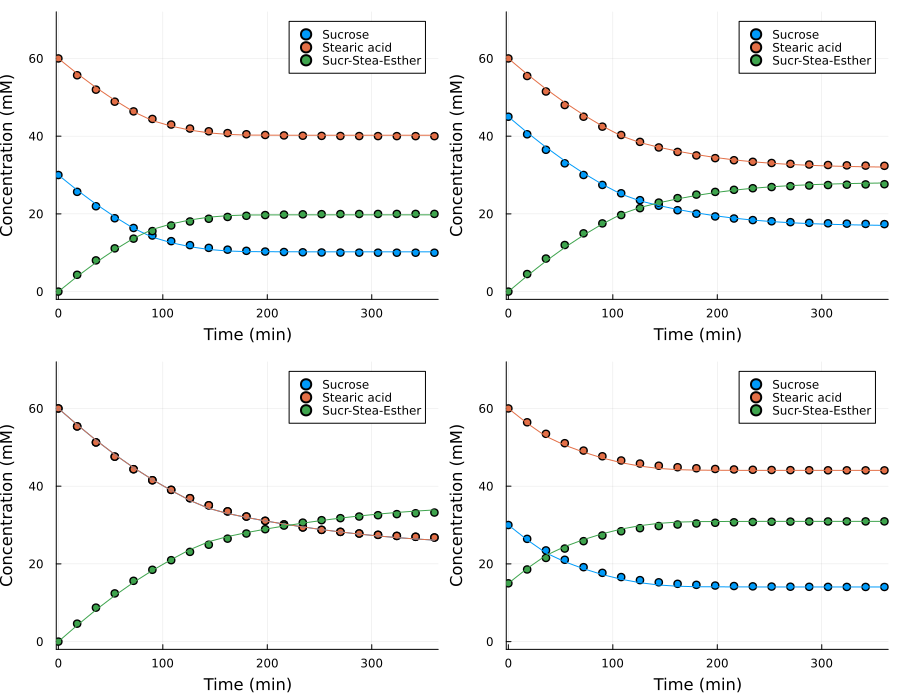

false

In [48]:
cb4()

## How well did we learn the true kinetics? 

To check how general the model is, the initial reaction rate is plotted as a function of the initial concentrations. In these figures the fatty acid concentration is kept constant.

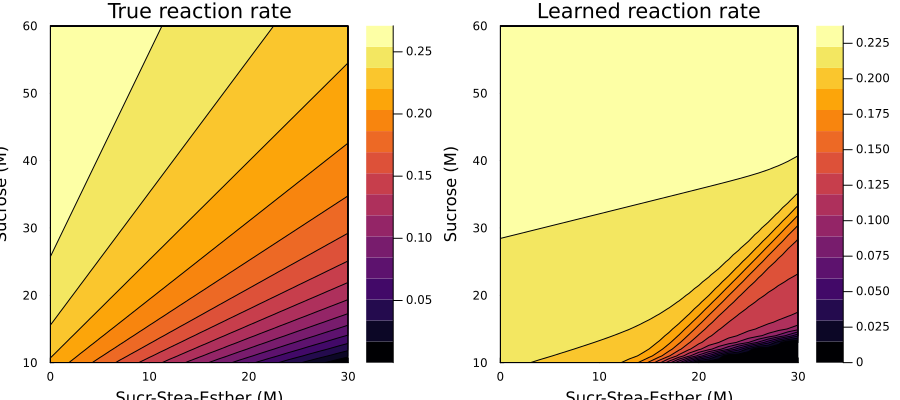

In [49]:
G = 10:1.0f0:60
L = 60.0f0
Es = 0.0:1.0f0:30.0

X = Iterators.product(G, L, Es)
l = @layout [a b]
c₁ = contourf(Es, G, rate.(X), 
        xlabel = "Sucr-Stea-Esther (M)", 
        ylabel="Sucrose (M)", 
        title="True reaction rate")

R = [dCdt([C[1]; C[2]; C[3]], p, 0.0)[3] for C in X]
c₂ = contourf(Es, G, min.(max.(R, 0.0), maximum(R)), 
        xlabel = "Sucr-Stea-Esther (M)", 
        ylabel="Sucrose (M)", 
        title="Learned reaction rate")

G = [C[1] for C in initialConditions]
Es = [C[3] for C in initialConditions]

#scatter!(Es, G, grid=false, label="")

plot(c₁, c₂, layout=l, size=(900, 400))

You can start seeing similarities. Do keep in mind that we only trained our model on 9 experiments. To further improve this we might need to perform some additional experiments at high glucose concentrations. However, in the [next notebook](./03-hybrid.ipynb) we will show that this model can already be generalised for production purposes. 

## Saving model parameters

In [50]:
open("model/trainedModel.csv", "w") do file
    for value in p
        println(file, value)
    end
end